In [1]:
!pip install catboost
!pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report,matthews_corrcoef,cohen_kappa_score,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
%matplotlib inline

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/SPUTnik-42/Comparative-Analysis-of-Machine-Learning-Models-for-Fraud-Detection-in-Ethereum-Transactions/main/data/transaction_dataset.csv')
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


# **Data Cleaning AND EDA**

---



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [5]:
# drop first two columns (Index, Adress)
df = df.iloc[:,2:]

In [6]:
df.select_dtypes(include=['float','int']).describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [7]:
df['FLAG'].value_counts()

FLAG
0    7662
1    2179
Name: count, dtype: int64

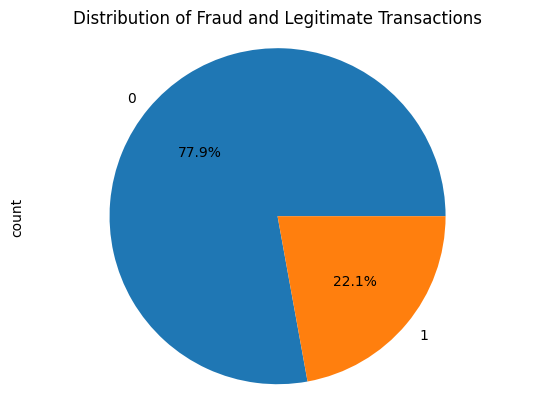

In [8]:
df["FLAG"].value_counts().plot(kind="pie",autopct='%1.1f%%')
plt.title('Distribution of Fraud and Legitimate Transactions')
plt.axis('equal')
plt.show()

In [9]:
df.isnull().sum()

Address                                                    0
FLAG                                                       0
Avg min between sent tnx                                   0
Avg min between received tnx                               0
Time Diff between first and last (Mins)                    0
Sent tnx                                                   0
Received Tnx                                               0
Number of Created Contracts                                0
Unique Received From Addresses                             0
Unique Sent To Addresses                                   0
min value received                                         0
max value received                                         0
avg val received                                           0
min val sent                                               0
max val sent                                               0
avg val sent                                               0
min value sent to contra

In [10]:
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,Address,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,StatusNetwork,EOS
...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,,GSENetwork
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,,Blockwell say NOTSAFU
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,,Free BOB Tokens - BobsRepair.com
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,NaN,NaN


In [11]:
df.drop(df[categories], axis=1, inplace=True)

In [12]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

In [13]:
df.isnull().sum()

FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent to contract                              0
max val sent to contract                                0
avg value sent

In [14]:
# Filtering the features with 0 variance
no_var = df.var() == 0
df.var()[no_var]

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64

In [15]:
df.drop(df.var()[no_var].index, axis = 1, inplace = True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 39 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

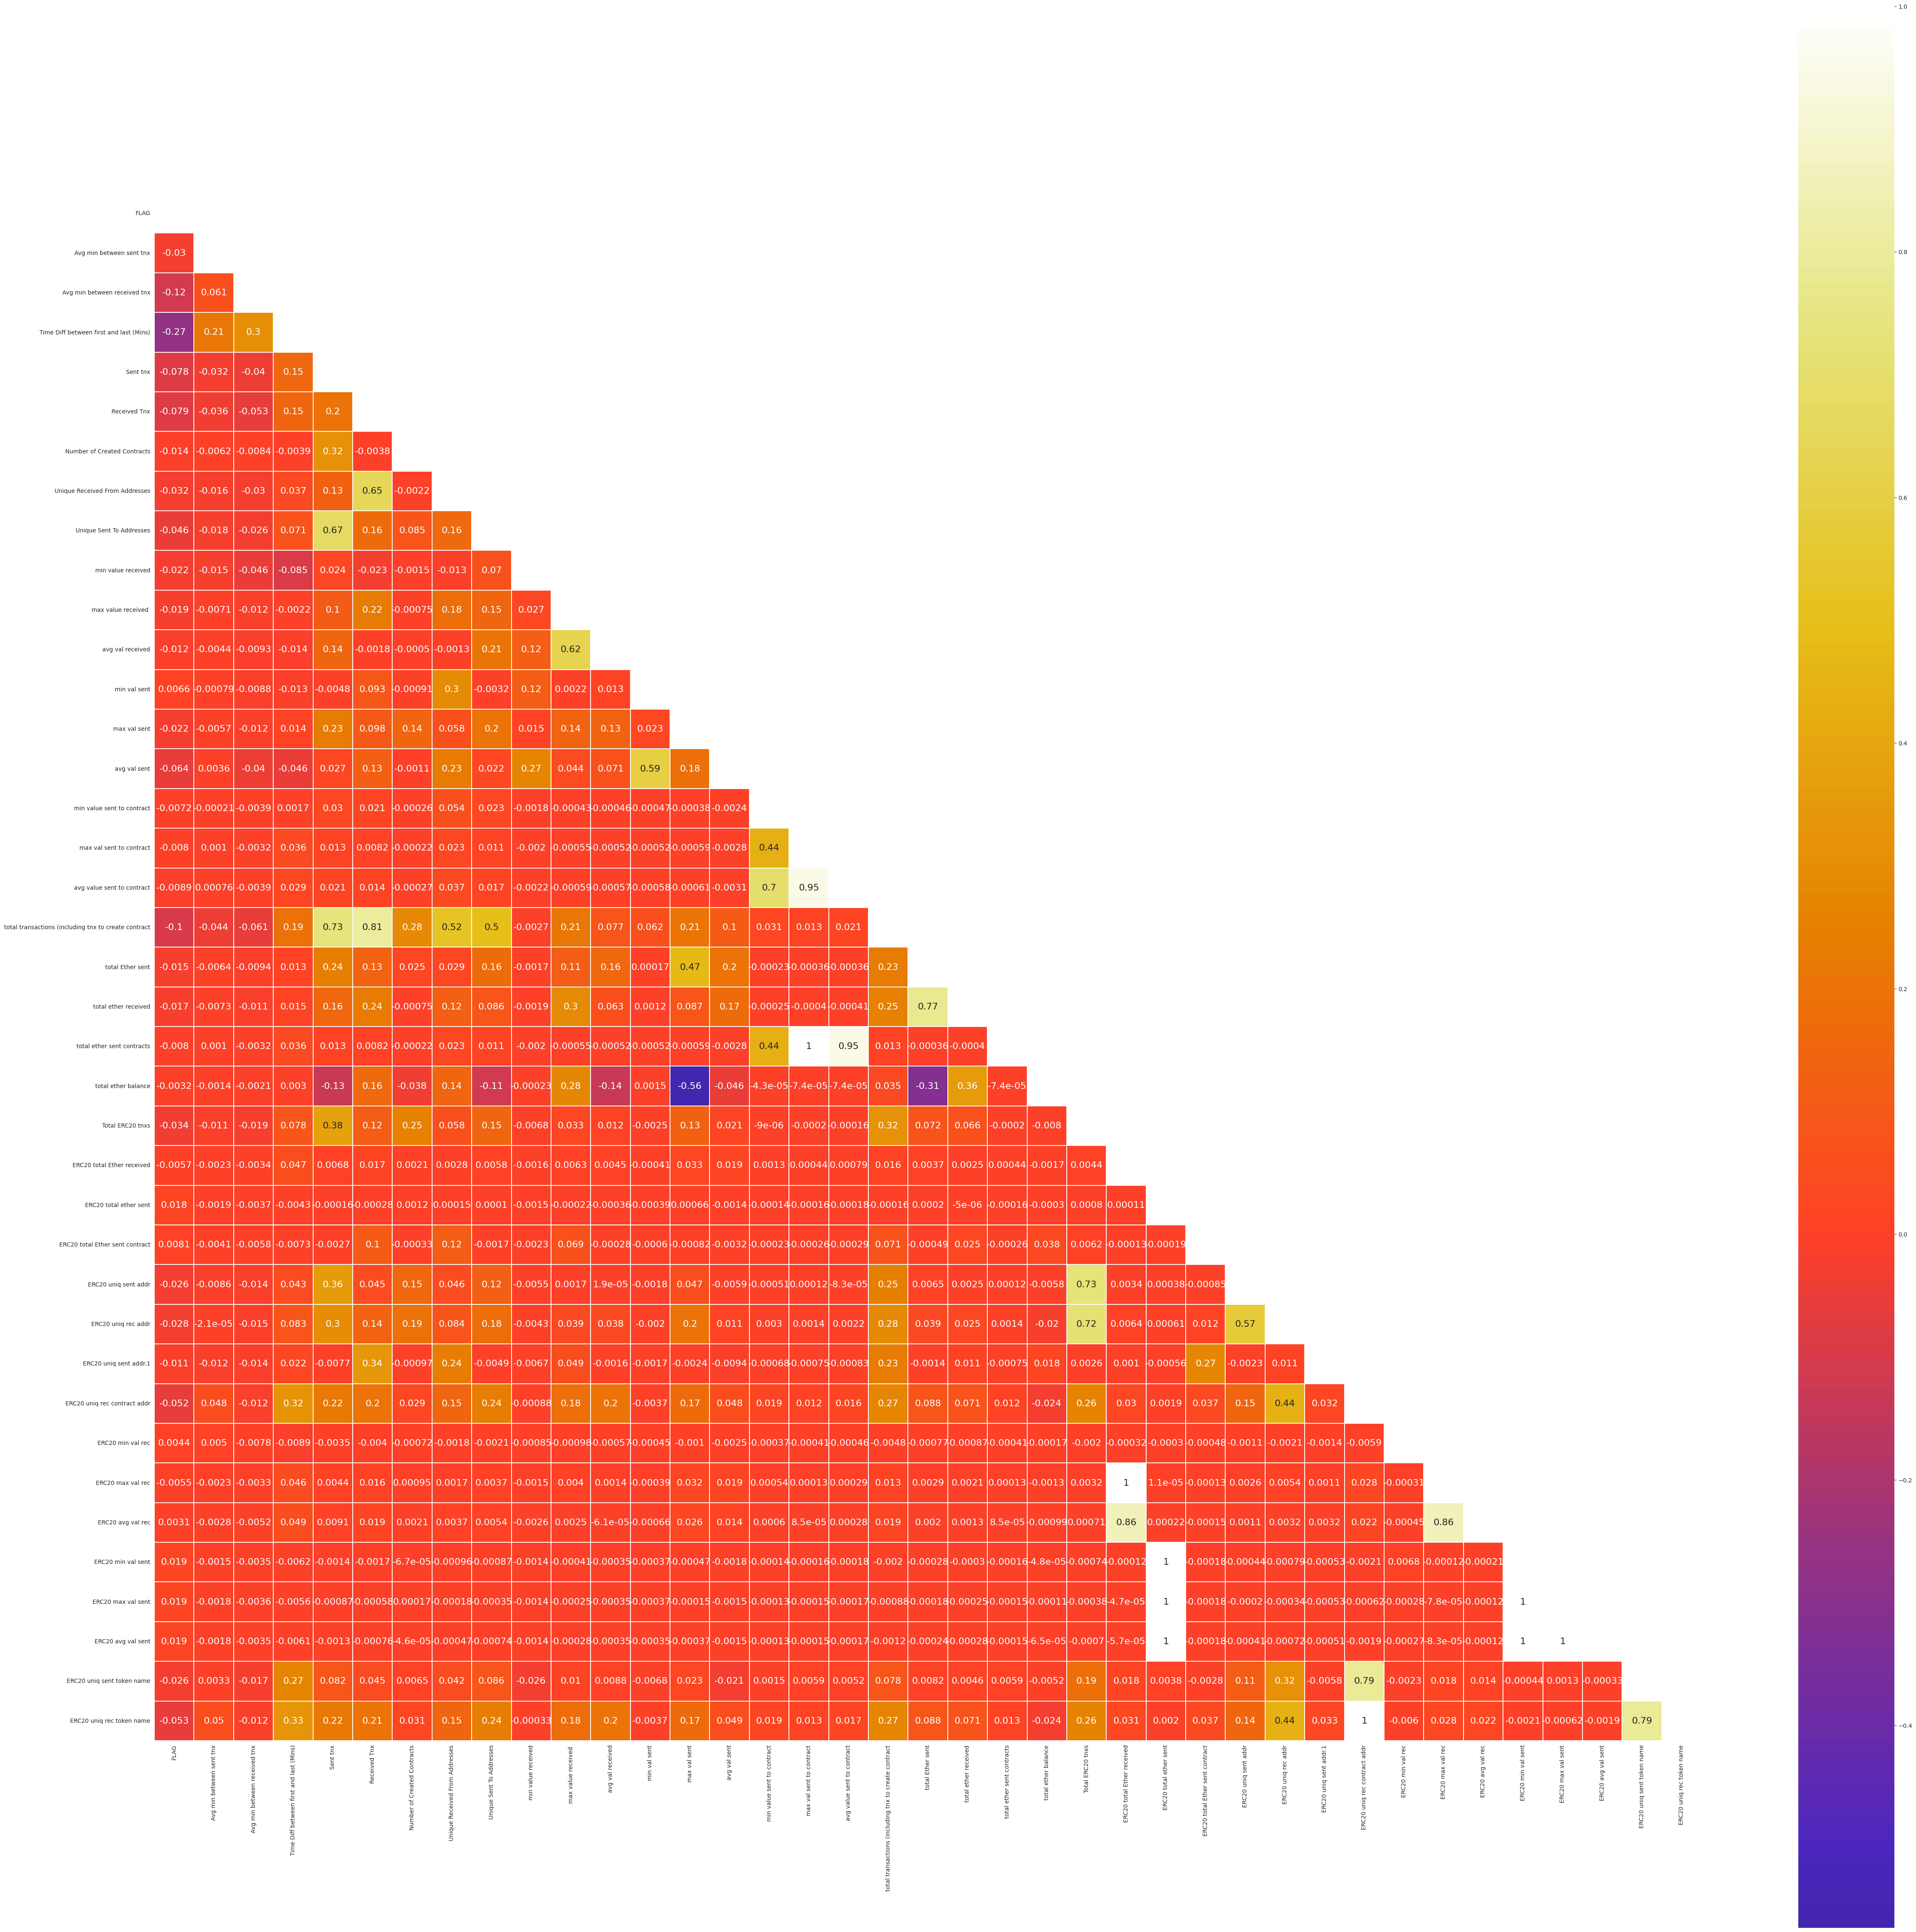

In [17]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(60,60))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='CMRmap', center=0, linewidths=0.1, square=True,annot_kws={"size": 16})

In [18]:
drop = ['total transactions (including tnx to create contract',
        'total ether sent contracts',
        'max val sent to contract',
        ' ERC20 avg val rec',
        ' ERC20 avg val rec',
        ' ERC20 max val rec',
        ' ERC20 min val rec',
        ' ERC20 uniq rec contract addr',
        'max val sent',
        ' ERC20 avg val sent',
        ' ERC20 min val sent',
        ' ERC20 max val sent',
        ' Total ERC20 tnxs',
        'avg value sent to contract',
        'Unique Sent To Addresses',
        'Unique Received From Addresses',
        'total ether received',
        ' ERC20 uniq sent token name',
        'min value received',
        'min val sent',
        ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

In [19]:
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
min value sent to contract
0.00    9839
0.02       1
0.01       1
Name: count, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
 ERC20 uniq sent addr.1
0.0    9813
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64


In [20]:
drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)

(9841, 17)


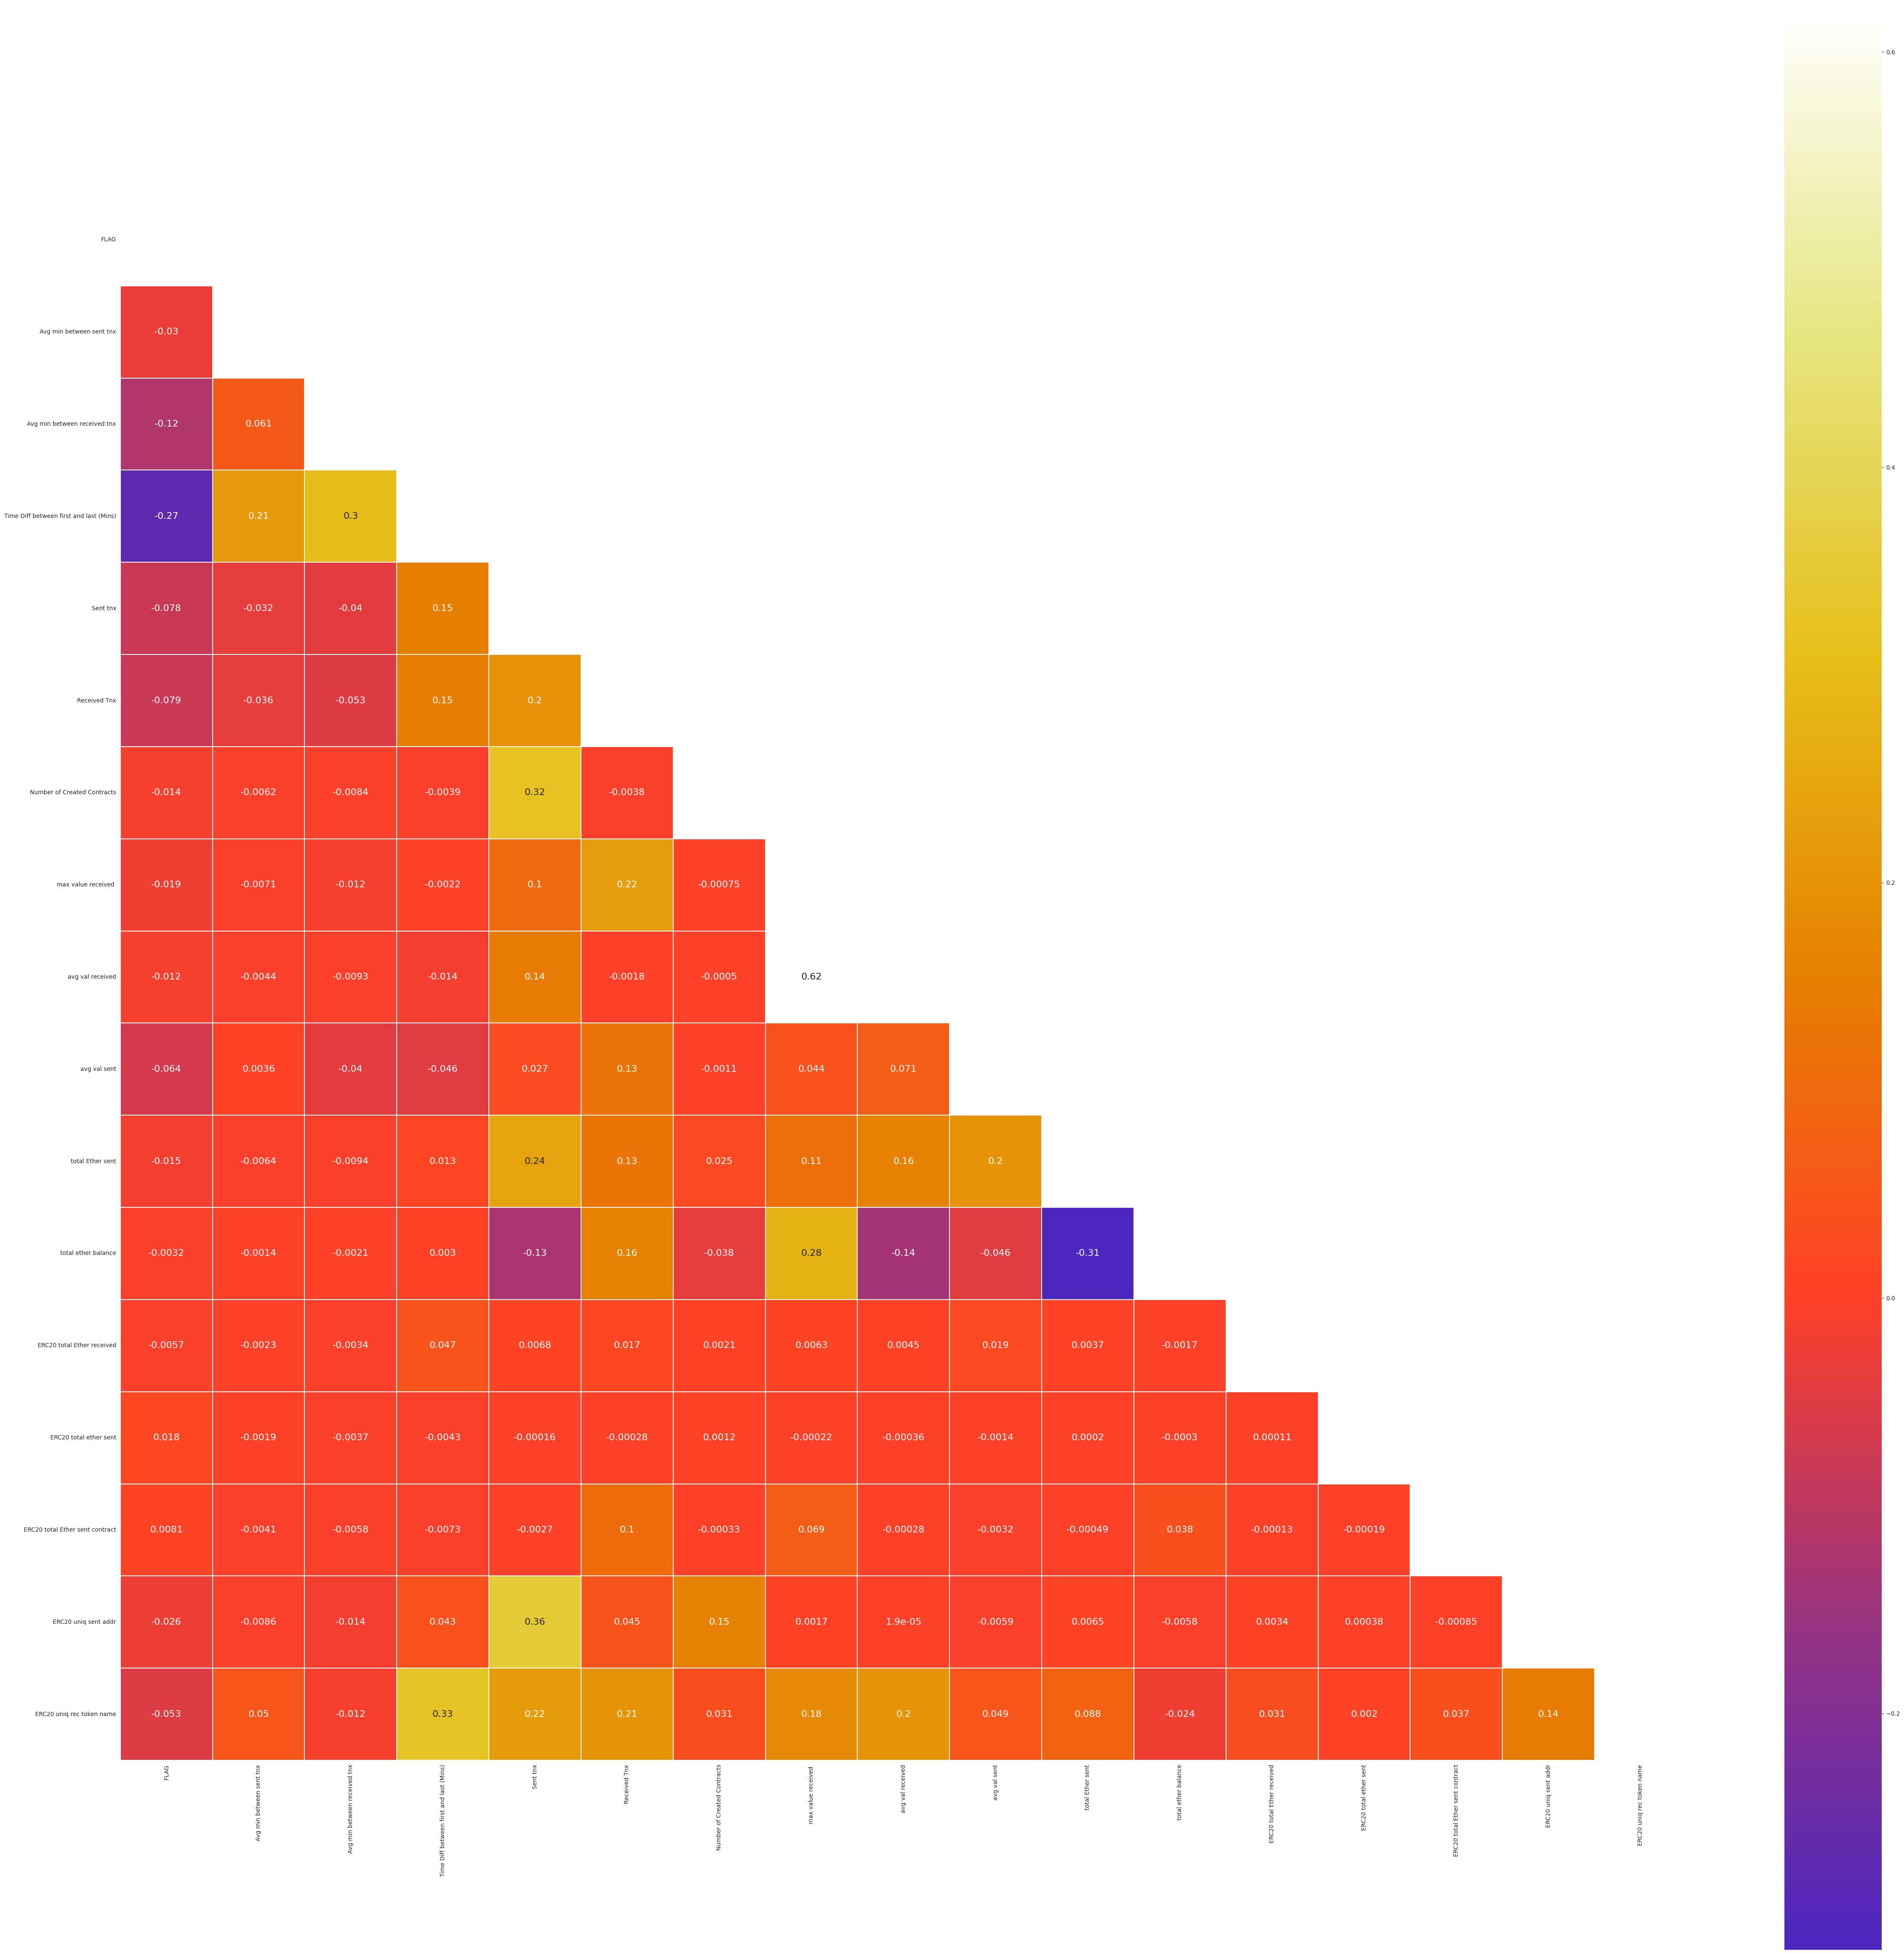

In [21]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(60,60))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='CMRmap', center=0, linewidths=0.1, square=True,annot_kws={"size": 16})

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   FLAG                                     9841 non-null   int64  
 1   Avg min between sent tnx                 9841 non-null   float64
 2   Avg min between received tnx             9841 non-null   float64
 3   Time Diff between first and last (Mins)  9841 non-null   float64
 4   Sent tnx                                 9841 non-null   int64  
 5   Received Tnx                             9841 non-null   int64  
 6   Number of Created Contracts              9841 non-null   int64  
 7   max value received                       9841 non-null   float64
 8   avg val received                         9841 non-null   float64
 9   avg val sent                             9841 non-null   float64
 10  total Ether sent                         9841 no

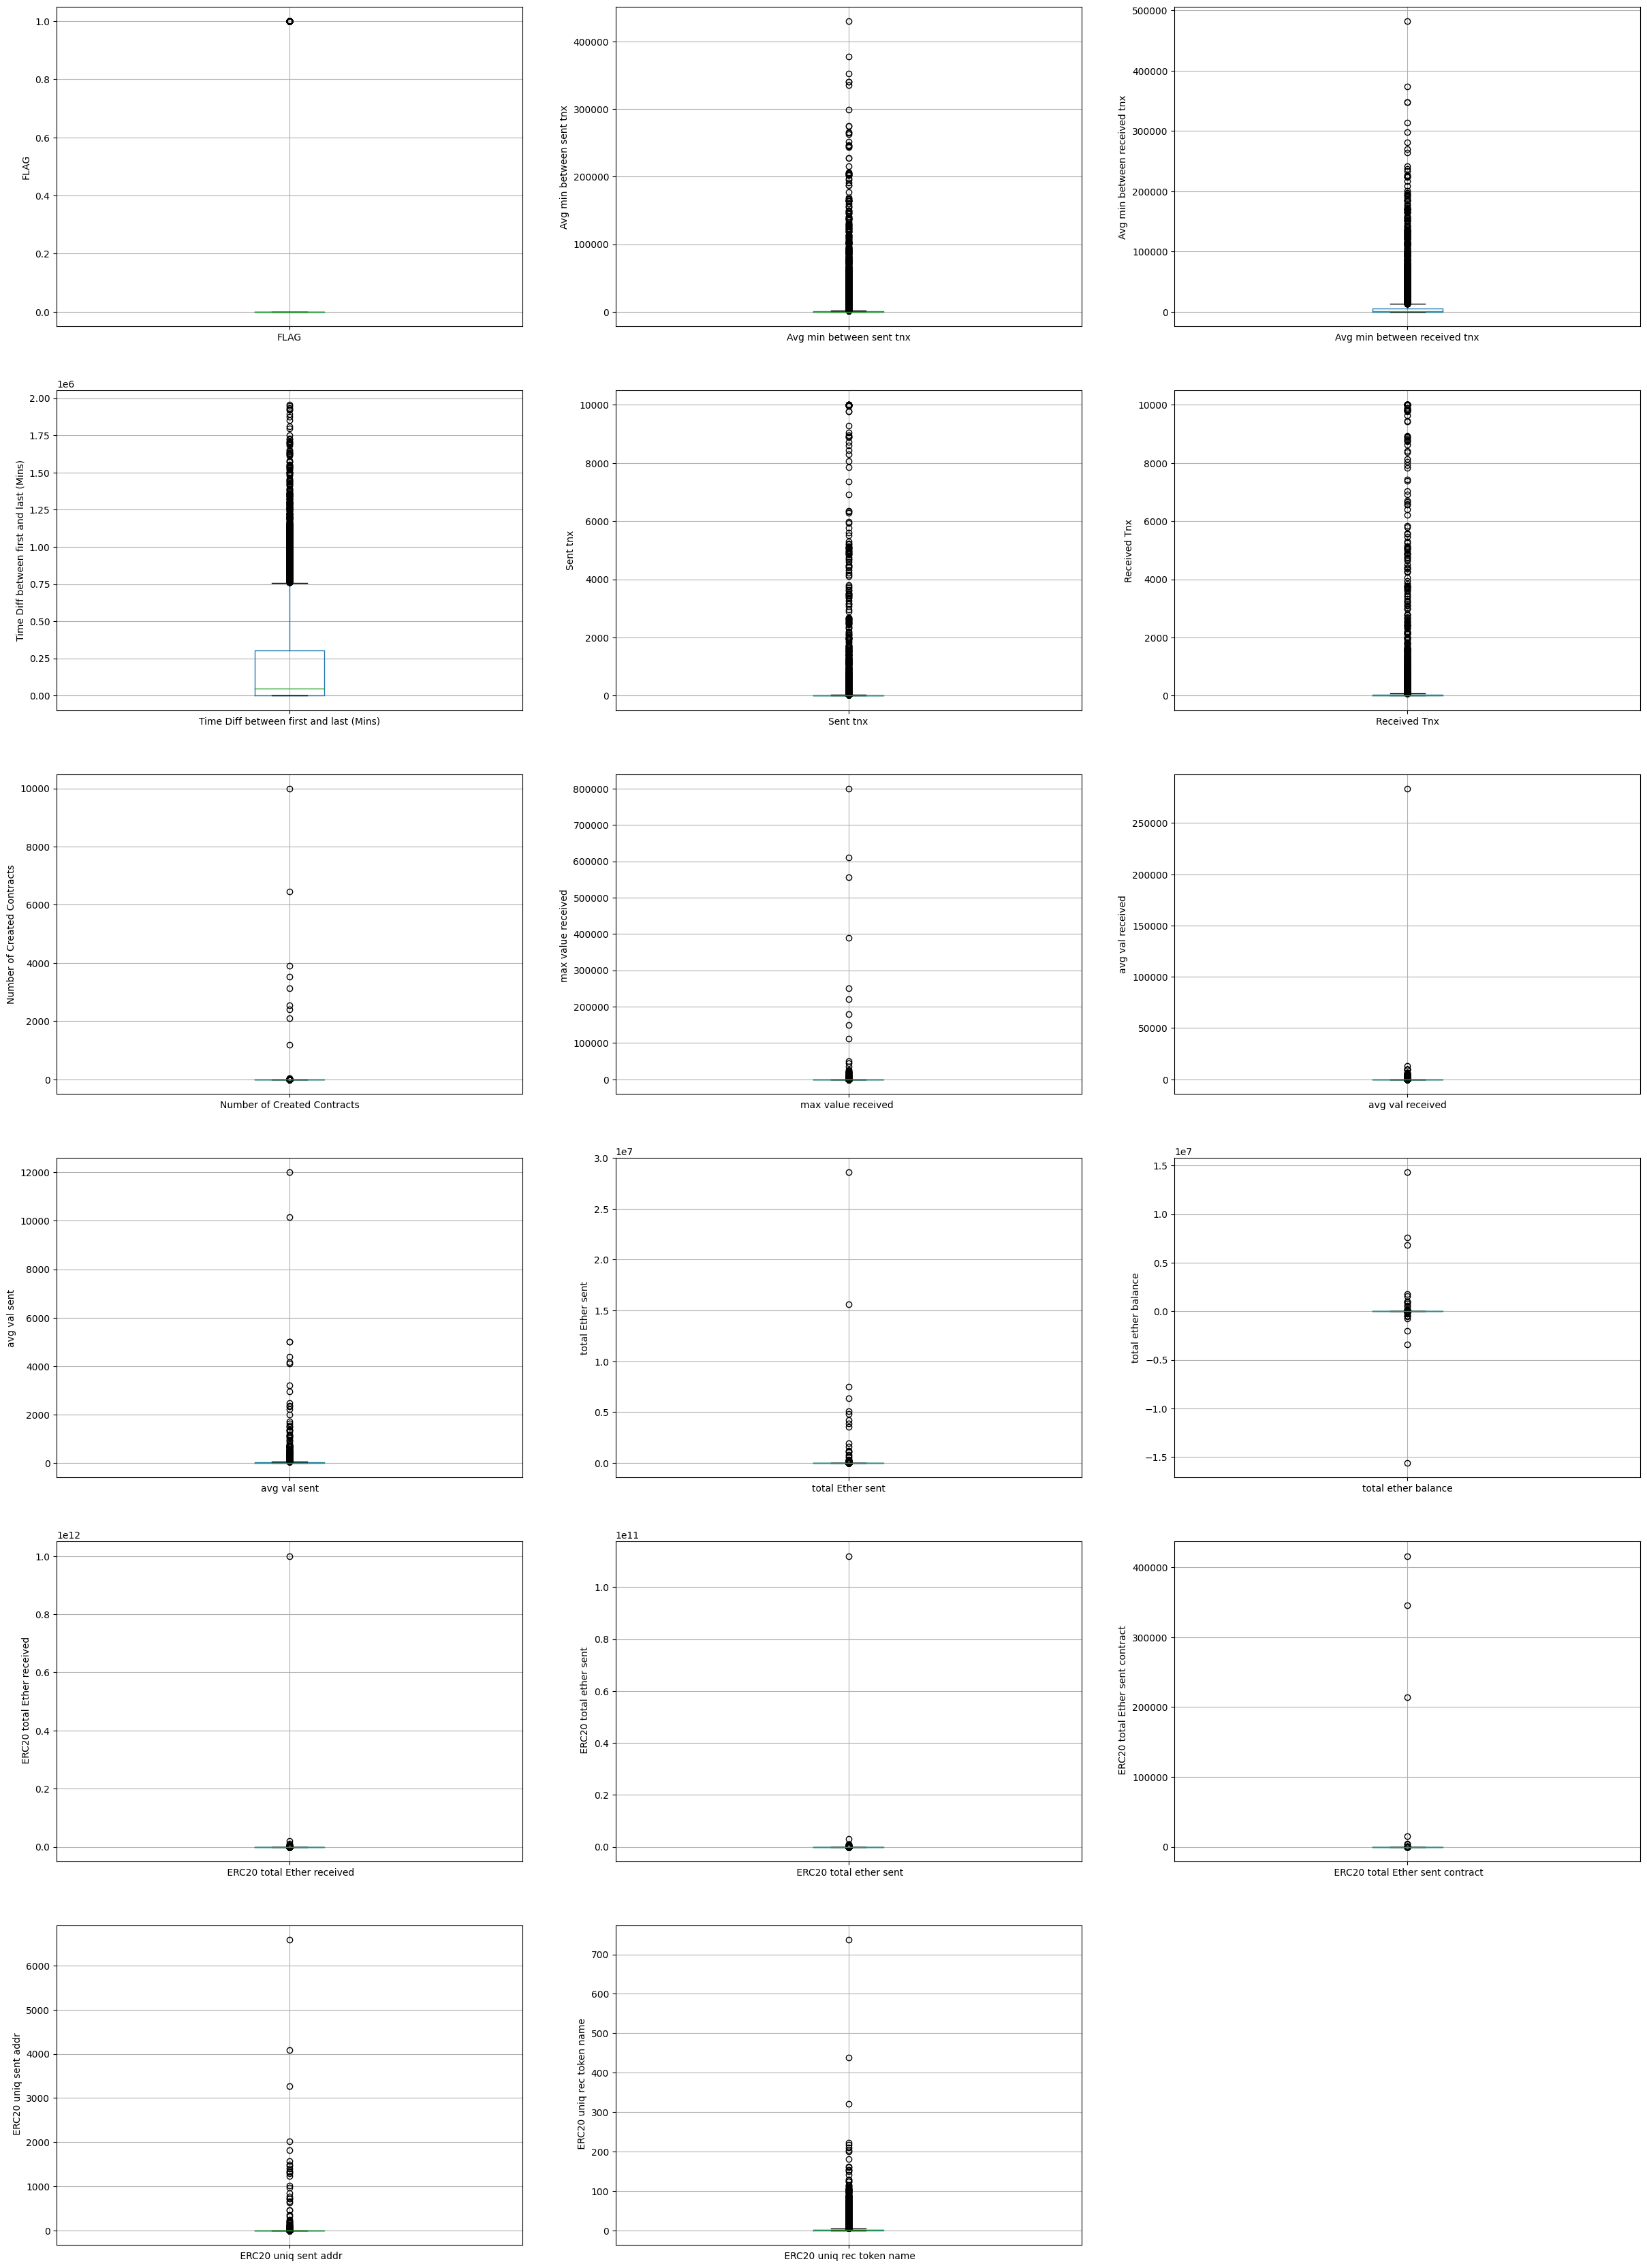

In [23]:
plt.figure(figsize=(30,50))

for i in range(len(df.columns)) :
  plt.subplot(7, 3, i+1)
  fig = df.boxplot(column=df.columns[i])
  fig.set_title('')
  fig.set_ylabel(df.columns[i])

# **Data Preparation**

In [24]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 16) (7872,)
(1969, 16) (1969,)


In [25]:
sc = StandardScaler()
sc_train = sc.fit_transform(X_train)

In [26]:
sc_df = pd.DataFrame(sc_train, columns=X_train.columns)

In [27]:
oversample = SMOTE()
x_tr_resample, y_tr_resample = oversample.fit_resample(sc_train, y_train)

In [28]:
# Target distribution before SMOTE
non_fraud = 0
fraud = 0

for i in y_train:
    if i == 0:
        non_fraud +=1
    else:
        fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_tr_resample:
    if j == 0:
        no +=1
    else:
        yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 1757
AFTER OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 6116


# **Logistic Regression**

In [29]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

LogisticRegression(random_state=42)

In [30]:
sc_test = sc.transform(X_test)
preds = LR.predict(sc_test)

In [31]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.54      0.69      1547
           1       0.34      0.87      0.49       422

    accuracy                           0.61      1969
   macro avg       0.64      0.70      0.59      1969
weighted avg       0.81      0.61      0.64      1969



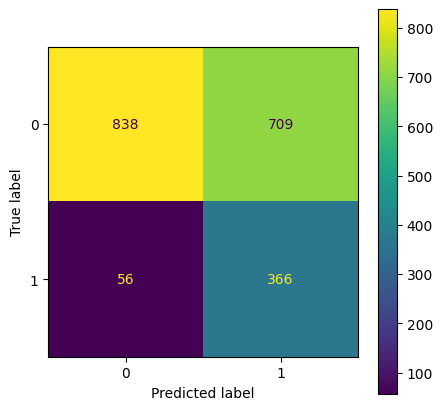

In [32]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [33]:
lrcr = classification_report(y_test, preds,output_dict=True)

lr_f_precision = lrcr['1']['precision']
lr_f_recall = lrcr['1']['recall']
lr_f_f1 = lrcr['1']['f1-score']
lr_acc = lrcr['accuracy']
lr_roc = roc_auc_score(y_test, preds)
lr_mcc = matthews_corrcoef(y_test, preds)
lr_kappa = cohen_kappa_score(y_test, preds)
lr_res = ['Logistic Regression',lr_f_precision,lr_f_recall,lr_f_f1,lr_acc,lr_roc,lr_mcc,lr_kappa]

# **Random Forest Classifier**

In [34]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(sc_test)

In [35]:
print(classification_report(y_test, preds_RF))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1547
           1       0.92      0.94      0.93       422

    accuracy                           0.97      1969
   macro avg       0.95      0.96      0.95      1969
weighted avg       0.97      0.97      0.97      1969



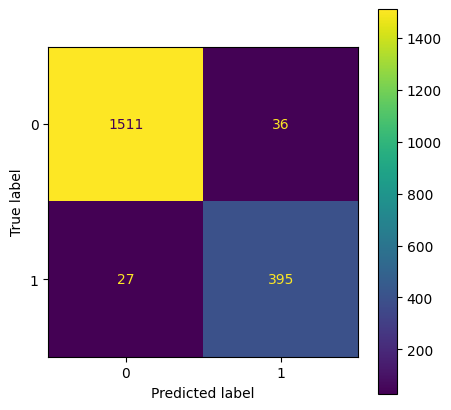

In [36]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_RF))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [37]:
rfccr = classification_report(y_test, preds_RF,output_dict=True)

rfc_f_precision = rfccr['1']['precision']
rfc_f_recall = rfccr['1']['recall']
rfc_f_f1 = rfccr['1']['f1-score']
rfc_acc = rfccr['accuracy']
rfc_roc = roc_auc_score(y_test, preds_RF)
rfc_mcc = matthews_corrcoef(y_test, preds_RF)
rfc_kappa = cohen_kappa_score(y_test, preds_RF)
rfc_res = ['Random Forest Classifier',rfc_f_precision,rfc_f_recall,rfc_f_f1,rfc_acc,rfc_roc,rfc_mcc,rfc_kappa]

# **XGBoost**

In [38]:
xgb_c = xgb.XGBClassifier(random_state=42)
xgb_c.fit(x_tr_resample, y_tr_resample)
preds_xgb = xgb_c.predict(sc_test)

In [39]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1547
           1       0.94      0.96      0.95       422

    accuracy                           0.98      1969
   macro avg       0.97      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969



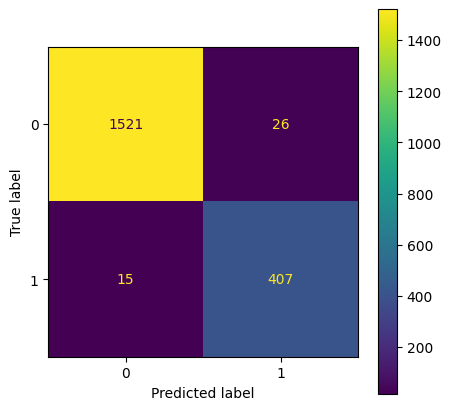

In [40]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_xgb))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [41]:
xgbcr = classification_report(y_test, preds_xgb,output_dict=True)

xgb_f_precision = xgbcr['1']['precision']
xgb_f_recall = xgbcr['1']['recall']
xgb_f_f1 = xgbcr['1']['f1-score']
xgb_acc = xgbcr['accuracy']
xgb_roc = roc_auc_score(y_test, preds_xgb)
xgb_mcc = matthews_corrcoef(y_test, preds_xgb)
xgb_kappa = cohen_kappa_score(y_test, preds_xgb)
xgb_res = ['XGBoost',xgb_f_precision,xgb_f_recall,xgb_f_f1,xgb_acc,xgb_roc,xgb_mcc,xgb_kappa]

# **CatBoost**

In [42]:
clf = CatBoostClassifier( iterations=13)
clf.fit(x_tr_resample, y_tr_resample,)
preds_clf = clf.predict(sc_test)

Learning rate set to 0.5
0:	learn: 0.4134591	total: 109ms	remaining: 1.31s
1:	learn: 0.2945747	total: 149ms	remaining: 817ms
2:	learn: 0.2254583	total: 206ms	remaining: 685ms
3:	learn: 0.1824279	total: 249ms	remaining: 561ms
4:	learn: 0.1584240	total: 293ms	remaining: 469ms
5:	learn: 0.1444166	total: 334ms	remaining: 389ms
6:	learn: 0.1282770	total: 369ms	remaining: 316ms
7:	learn: 0.1223220	total: 420ms	remaining: 262ms
8:	learn: 0.1156621	total: 465ms	remaining: 207ms
9:	learn: 0.1108886	total: 497ms	remaining: 149ms
10:	learn: 0.1074967	total: 536ms	remaining: 97.5ms
11:	learn: 0.0998337	total: 575ms	remaining: 47.9ms
12:	learn: 0.0961606	total: 619ms	remaining: 0us


In [43]:
print(classification_report(y_test, preds_clf))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1547
           1       0.86      0.95      0.91       422

    accuracy                           0.96      1969
   macro avg       0.92      0.96      0.94      1969
weighted avg       0.96      0.96      0.96      1969



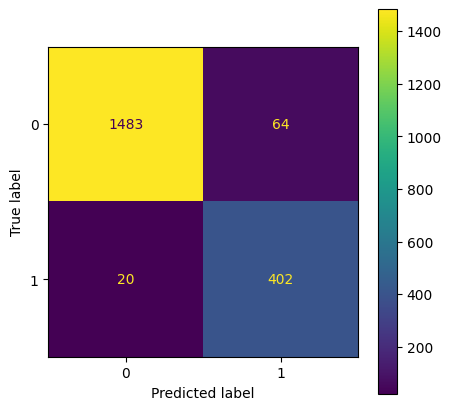

In [44]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_clf))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [45]:
clfcr = classification_report(y_test, preds_clf,output_dict=True)

clf_f_precision = clfcr['1']['precision']
clf_f_recall = clfcr['1']['recall']
clf_f_f1 = clfcr['1']['f1-score']
clf_acc = clfcr['accuracy']
clf_roc = roc_auc_score(y_test, preds_clf)
clf_mcc = matthews_corrcoef(y_test, preds_clf)
clf_kappa = cohen_kappa_score(y_test, preds_clf)
clf_res = ['CatBoost',clf_f_precision,clf_f_recall,clf_f_f1,clf_acc,clf_roc,clf_mcc,clf_kappa]

# **LightGBM**

In [46]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(x_tr_resample, y_tr_resample,)
preds_lgbm = lgbm.predict(sc_test)

[LightGBM] [Info] Number of positive: 6115, number of negative: 6115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 12230, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [47]:
print(classification_report(y_test, preds_lgbm))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1547
           1       0.94      0.97      0.96       422

    accuracy                           0.98      1969
   macro avg       0.97      0.98      0.97      1969
weighted avg       0.98      0.98      0.98      1969



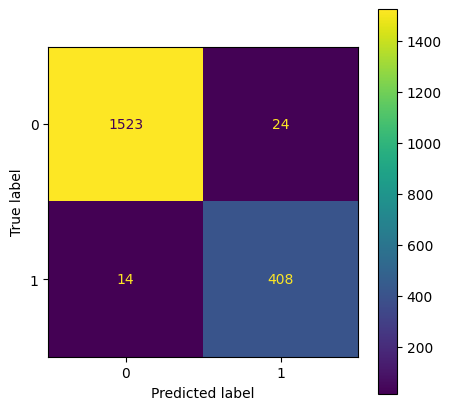

In [48]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_lgbm))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [49]:
lgbmcr = classification_report(y_test, preds_lgbm,output_dict=True)

lgbm_f_precision = lgbmcr['1']['precision']
lgbm_f_recall = lgbmcr['1']['recall']
lgbm_f_f1 = lgbmcr['1']['f1-score']
lgbm_acc = lgbmcr['accuracy']
lgbm_roc = roc_auc_score(y_test, preds_lgbm)
lgbm_mcc = matthews_corrcoef(y_test, preds_lgbm)
lgbm_kappa = cohen_kappa_score(y_test, preds_lgbm)
lgbm_res = ['LightGBM',lgbm_f_precision,lgbm_f_recall,lgbm_f_f1,lgbm_acc,lgbm_roc,lgbm_mcc,lgbm_kappa]

# **AdaBoost**

In [50]:
ada = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
ada.fit(x_tr_resample, y_tr_resample,)
preds_ada = ada.predict(sc_test)

In [51]:
print(classification_report(y_test, preds_ada))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1547
           1       0.84      0.93      0.88       422

    accuracy                           0.95      1969
   macro avg       0.91      0.94      0.92      1969
weighted avg       0.95      0.95      0.95      1969



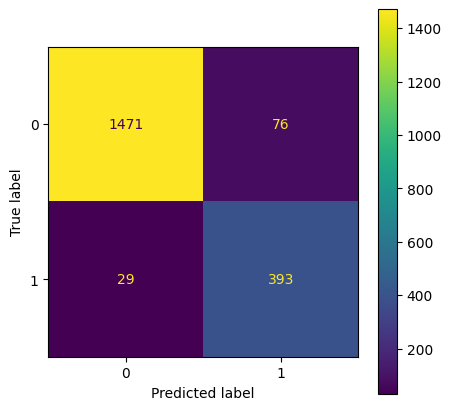

In [52]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_ada))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [53]:
adacr = classification_report(y_test, preds_ada,output_dict=True)

ada_f_precision = adacr['1']['precision']
ada_f_recall = adacr['1']['recall']
ada_f_f1 = adacr['1']['f1-score']
ada_acc = adacr['accuracy']
ada_roc = roc_auc_score(y_test, preds_ada)
ada_mcc = matthews_corrcoef(y_test, preds_ada)
ada_kappa = cohen_kappa_score(y_test, preds_ada)
ada_res = ['AdaBoost',ada_f_precision,ada_f_recall,ada_f_f1,ada_acc,ada_roc,ada_mcc,ada_kappa]

# **SVC**

In [54]:
svc=SVC()
svc.fit(x_tr_resample, y_tr_resample,)
preds_svc = svc.predict(sc_test)

In [55]:
print(classification_report(y_test, preds_svc))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1547
           1       0.53      0.87      0.66       422

    accuracy                           0.81      1969
   macro avg       0.75      0.83      0.76      1969
weighted avg       0.87      0.81      0.82      1969



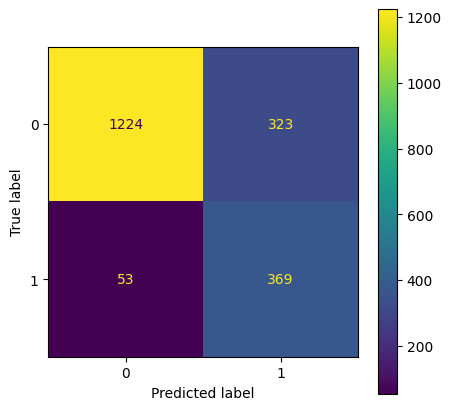

In [56]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_svc))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [57]:
svccr = classification_report(y_test, preds_svc,output_dict=True)

svc_f_precision = svccr['1']['precision']
svc_f_recall = svccr['1']['recall']
svc_f_f1 = svccr['1']['f1-score']
svc_acc = svccr['accuracy']
svc_roc = roc_auc_score(y_test, preds_svc)
svc_mcc = matthews_corrcoef(y_test, preds_svc)
svc_kappa = cohen_kappa_score(y_test, preds_svc)
svc_res = ['SVC',svc_f_precision,svc_f_recall,svc_f_f1,svc_acc,svc_roc,svc_mcc,svc_kappa]

# **KNN**

In [58]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_tr_resample, y_tr_resample,)
preds_knn = knn.predict(sc_test)

In [59]:
print(classification_report(y_test, preds_knn))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1547
           1       0.77      0.91      0.83       422

    accuracy                           0.92      1969
   macro avg       0.87      0.92      0.89      1969
weighted avg       0.93      0.92      0.92      1969



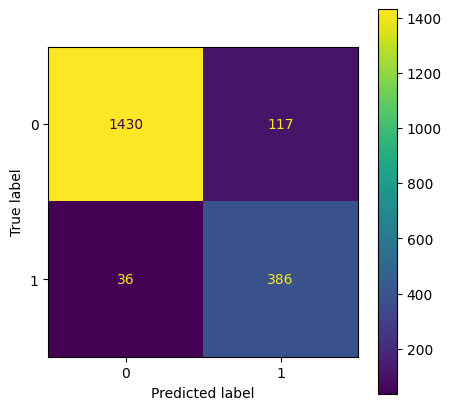

In [60]:
display = ConfusionMatrixDisplay(confusion_matrix(y_test, preds_knn))
fig, ax = plt.subplots(figsize=(5,5))
display.plot(ax=ax)

In [61]:
knncr = classification_report(y_test, preds_knn,output_dict=True)

knn_f_precision = knncr['1']['precision']
knn_f_recall = knncr['1']['recall']
knn_f_f1 = knncr['1']['f1-score']
knn_acc = knncr['accuracy']
knn_roc = roc_auc_score(y_test, preds_knn)
knn_mcc = matthews_corrcoef(y_test, preds_knn)
knn_kappa = cohen_kappa_score(y_test, preds_knn)
knn_res = ['KNN',knn_f_precision,knn_f_recall,knn_f_f1,knn_acc,knn_roc,knn_mcc,knn_kappa]

# **Results**

In [64]:
models = ['Logistic Regression', 'Random Forest Classifier','XGBoost','CatBoost','LightGBM','AdaBoost','SVC','KNN']
res = pd.DataFrame(data =[lr_res, rfc_res, xgb_res,clf_res,lgbm_res,ada_res,svc_res,knn_res] , columns=['Models','precision','recall_score','f1_score','accuracy','AUC','MCC','kappa'] )
res

,Models,precision,recall_score,f1_score,accuracy,AUC,MCC,kappa
0,Logistic Regression,0.340465,0.867299,0.488978,0.611478,0.704496,0.337088,0.261731
1,Random Forest Classifier,0.916473,0.936019,0.926143,0.968004,0.956374,0.905807,0.905725
2,XGBoost,0.939954,0.964455,0.952047,0.979177,0.973824,0.938878,0.938751
3,CatBoost,0.862661,0.952607,0.905405,0.957339,0.955618,0.879751,0.877952
4,LightGBM,0.944444,0.966825,0.955504,0.980701,0.975655,0.943289,0.943184
5,AdaBoost,0.837953,0.931280,0.882155,0.946673,0.941076,0.849792,0.847819
6,SVC,0.533237,0.874408,0.662478,0.809040,0.832808,0.572107,0.539993
7,KNN,0.767396,0.914692,0.834595,0.922296,0.919531,0.789486,0.784322
